#### 结点特征对比

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

root_path = "../output/cv"
class_label_to_calculate = 1
metric_list = sorted(os.listdir(root_path))


def calculate_metrics(file_path, class_label=1):
    # Load the saved data
    loaded_data = np.load(file_path)

    # Access the saved arrays using the corresponding keys
    if 'label' in list(loaded_data.keys()):
        labels = loaded_data['label']
        probabilities = loaded_data['prob']
    elif 'labels' in list(loaded_data.keys()):
        labels = loaded_data['labels']
        probabilities = loaded_data['predictions']    
    elif 'groundtruth' in list(loaded_data.keys()):
        labels = loaded_data['groundtruth']
        probabilities = loaded_data['predict']
    # Calculate predicted labels
    if len(probabilities.shape) >= 2:
        predicted_labels = np.argmax(probabilities, axis=1)
    else:
        predicted_labels = probabilities

    if len(labels.shape) >= 2:
        labels = np.argmax(labels, axis=1)
    else:
        labels = labels

    # Calculate precision, recall, and F1-score for the specified class
    precision = precision_score(labels, predicted_labels, pos_label=class_label)
    recall = recall_score(labels, predicted_labels, pos_label=class_label)
    f1 = f1_score(labels, predicted_labels, pos_label=class_label)
    fpr, tpr, thresholds = roc_curve(labels, probabilities[:, class_label])
    roc_auc = auc(fpr, tpr)

    return precision, recall, f1, fpr, tpr, roc_auc

# Initialize an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1-Score', 'AUC'])

# Function to calculate metrics and update the DataFrame
def update_result_df(file_path, class_label=1):
    precision, recall, f1, fpr, tpr, roc_auc = calculate_metrics(file_path, class_label)
    return pd.Series({'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': roc_auc})

# Iterate through each file in metric_list
for metric_file in metric_list:
    file_path = os.path.join(root_path, metric_file)

    # Skip non-npz files
    if not metric_file.endswith('.npz'):
        continue

    # Calculate metrics and append the results to the DataFrame
    result_df.loc[metric_file.replace(".npz", "")] = update_result_df(file_path, class_label_to_calculate)

In [2]:
# 计算每个指标的平均值和标准差
mean_values = result_df.mean()
std_values = result_df.std()

# 创建一个新行，用于存储“平均值 ± 标准差”的形式
avg_std_row = round(mean_values,3).astype(str) + " ± " + round(std_values,3).astype(str)

# 将这个新行添加到DataFrame的底部
# 由于DataFrame的尺寸不匹配，我们可以先转换avg_std_row为DataFrame，然后再追加
avg_std_df = pd.DataFrame([avg_std_row], columns=result_df.columns, index=['Avg ± Std'])

# 将avg_std_df追加到原始的df_results中
df_results_with_avg_std = pd.concat([result_df, avg_std_df])

df_results_with_avg_std

,Precision,Recall,F1-Score,AUC
01,0.968254,0.924242,0.945736,0.968153
02,0.968254,0.924242,0.945736,0.944528
03,0.983607,0.909091,0.944882,0.96047
04,0.967213,0.893939,0.929134,0.926145
05,0.983871,0.924242,0.953125,0.933218
Avg ± Std,0.974 ± 0.009,0.915 ± 0.014,0.944 ± 0.009,0.947 ± 0.018


In [4]:
df_results_with_avg_std.to_csv("result/cv.csv",encoding="utf_8_sig")
df_results_with_avg_std

,Precision,Recall,F1-Score,AUC
01,0.968254,0.924242,0.945736,0.968153
02,0.968254,0.924242,0.945736,0.944528
03,0.983607,0.909091,0.944882,0.96047
04,0.967213,0.893939,0.929134,0.926145
05,0.983871,0.924242,0.953125,0.933218
Avg ± Std,0.974 ± 0.009,0.915 ± 0.014,0.944 ± 0.009,0.947 ± 0.018


In [21]:
loaded_data = np.load(root_path + "/" + metric_list[-1])
labels = loaded_data['label']
probabilities = loaded_data['prob']

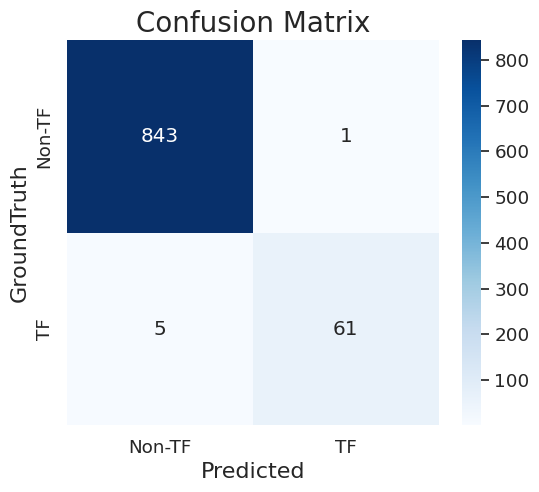

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
cm = confusion_matrix(labels, probabilities.argmax(1))
cm_df = pd.DataFrame(cm)
cm_df.index= ["Non-TF","TF"]
cm_df.columns= ["Non-TF","TF"]
sns.set(font_scale=1.2)  # 设置字体大小
# 使用seaborn库绘制热图
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted', size=16)
plt.ylabel('GroundTruth', size=16)
plt.title('Confusion Matrix', size=20)
plt.savefig("plot/best_cv_confusion_matrix",dpi=300)
plt.show()
